In [1]:
!pip install numpy pandas seaborn matplotlib scikit-learn imbalanced-learn shap streamlit joblib


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
# Load Dataset
df = pd.read_csv("CP_imputedFinal.csv")
# Display first
#  few rows
df.head()

Unnamed: 0       Category  Age Sex   ALB   ALP   ALT   AST   BIL    CHE  \
0           1  0=Blood Donor   32   m  38.5  52.5   7.7  22.1   7.5   6.93   
1           2  0=Blood Donor   32   m  38.5  70.3  18.0  24.7   3.9  11.17   
2           3  0=Blood Donor   32   m  46.9  74.7  36.2  52.6   6.1   8.84   
3           4  0=Blood Donor   32   m  43.2  52.0  30.6  22.6  18.9   7.33   
4           5  0=Blood Donor   32   m  39.2  74.1  32.6  24.8   9.6   9.15   

   CHOL   CREA   GGT  PROT  
0  3.23  106.0  12.1  69.0  
1  4.80   74.0  15.6  76.5  
2  5.20   86.0  33.2  79.3  
3  4.74   80.0  33.8  75.7  
4  4.32   76.0  29.9  68.7

In [51]:
df['Category'].value_counts()

Category
0=Blood Donor             533
3=Cirrhosis                30
1=Hepatitis                24
2=Fibrosis                 21
0s=suspect Blood Donor      7
Name: count, dtype: int64

In [52]:
if 'Unnamed: 0' in df.columns:
    df.drop(columns = ['Unnamed: 0'], inplace = True)
df.dtypes

Category     object
Age           int64
Sex          object
ALB         float64
ALP         float64
ALT         float64
AST         float64
BIL         float64
CHE         float64
CHOL        float64
CREA        float64
GGT         float64
PROT        float64
dtype: object

In [53]:
# Check for missing values
print("Missing values per column:\n", df.isnull().sum())

Missing values per column:
 Category     0
Age          0
Sex          0
ALB          1
ALP         18
ALT          1
AST          0
BIL          0
CHE          0
CHOL        10
CREA         0
GGT          0
PROT         1
dtype: int64


In [55]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical columns
label_encoder = LabelEncoder()
df['Sex'] = label_encoder.fit_transform(df['Sex'])
# df['Category'] = label_encoder.fit_transform(df['Category'])  # Target variable

In [48]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]


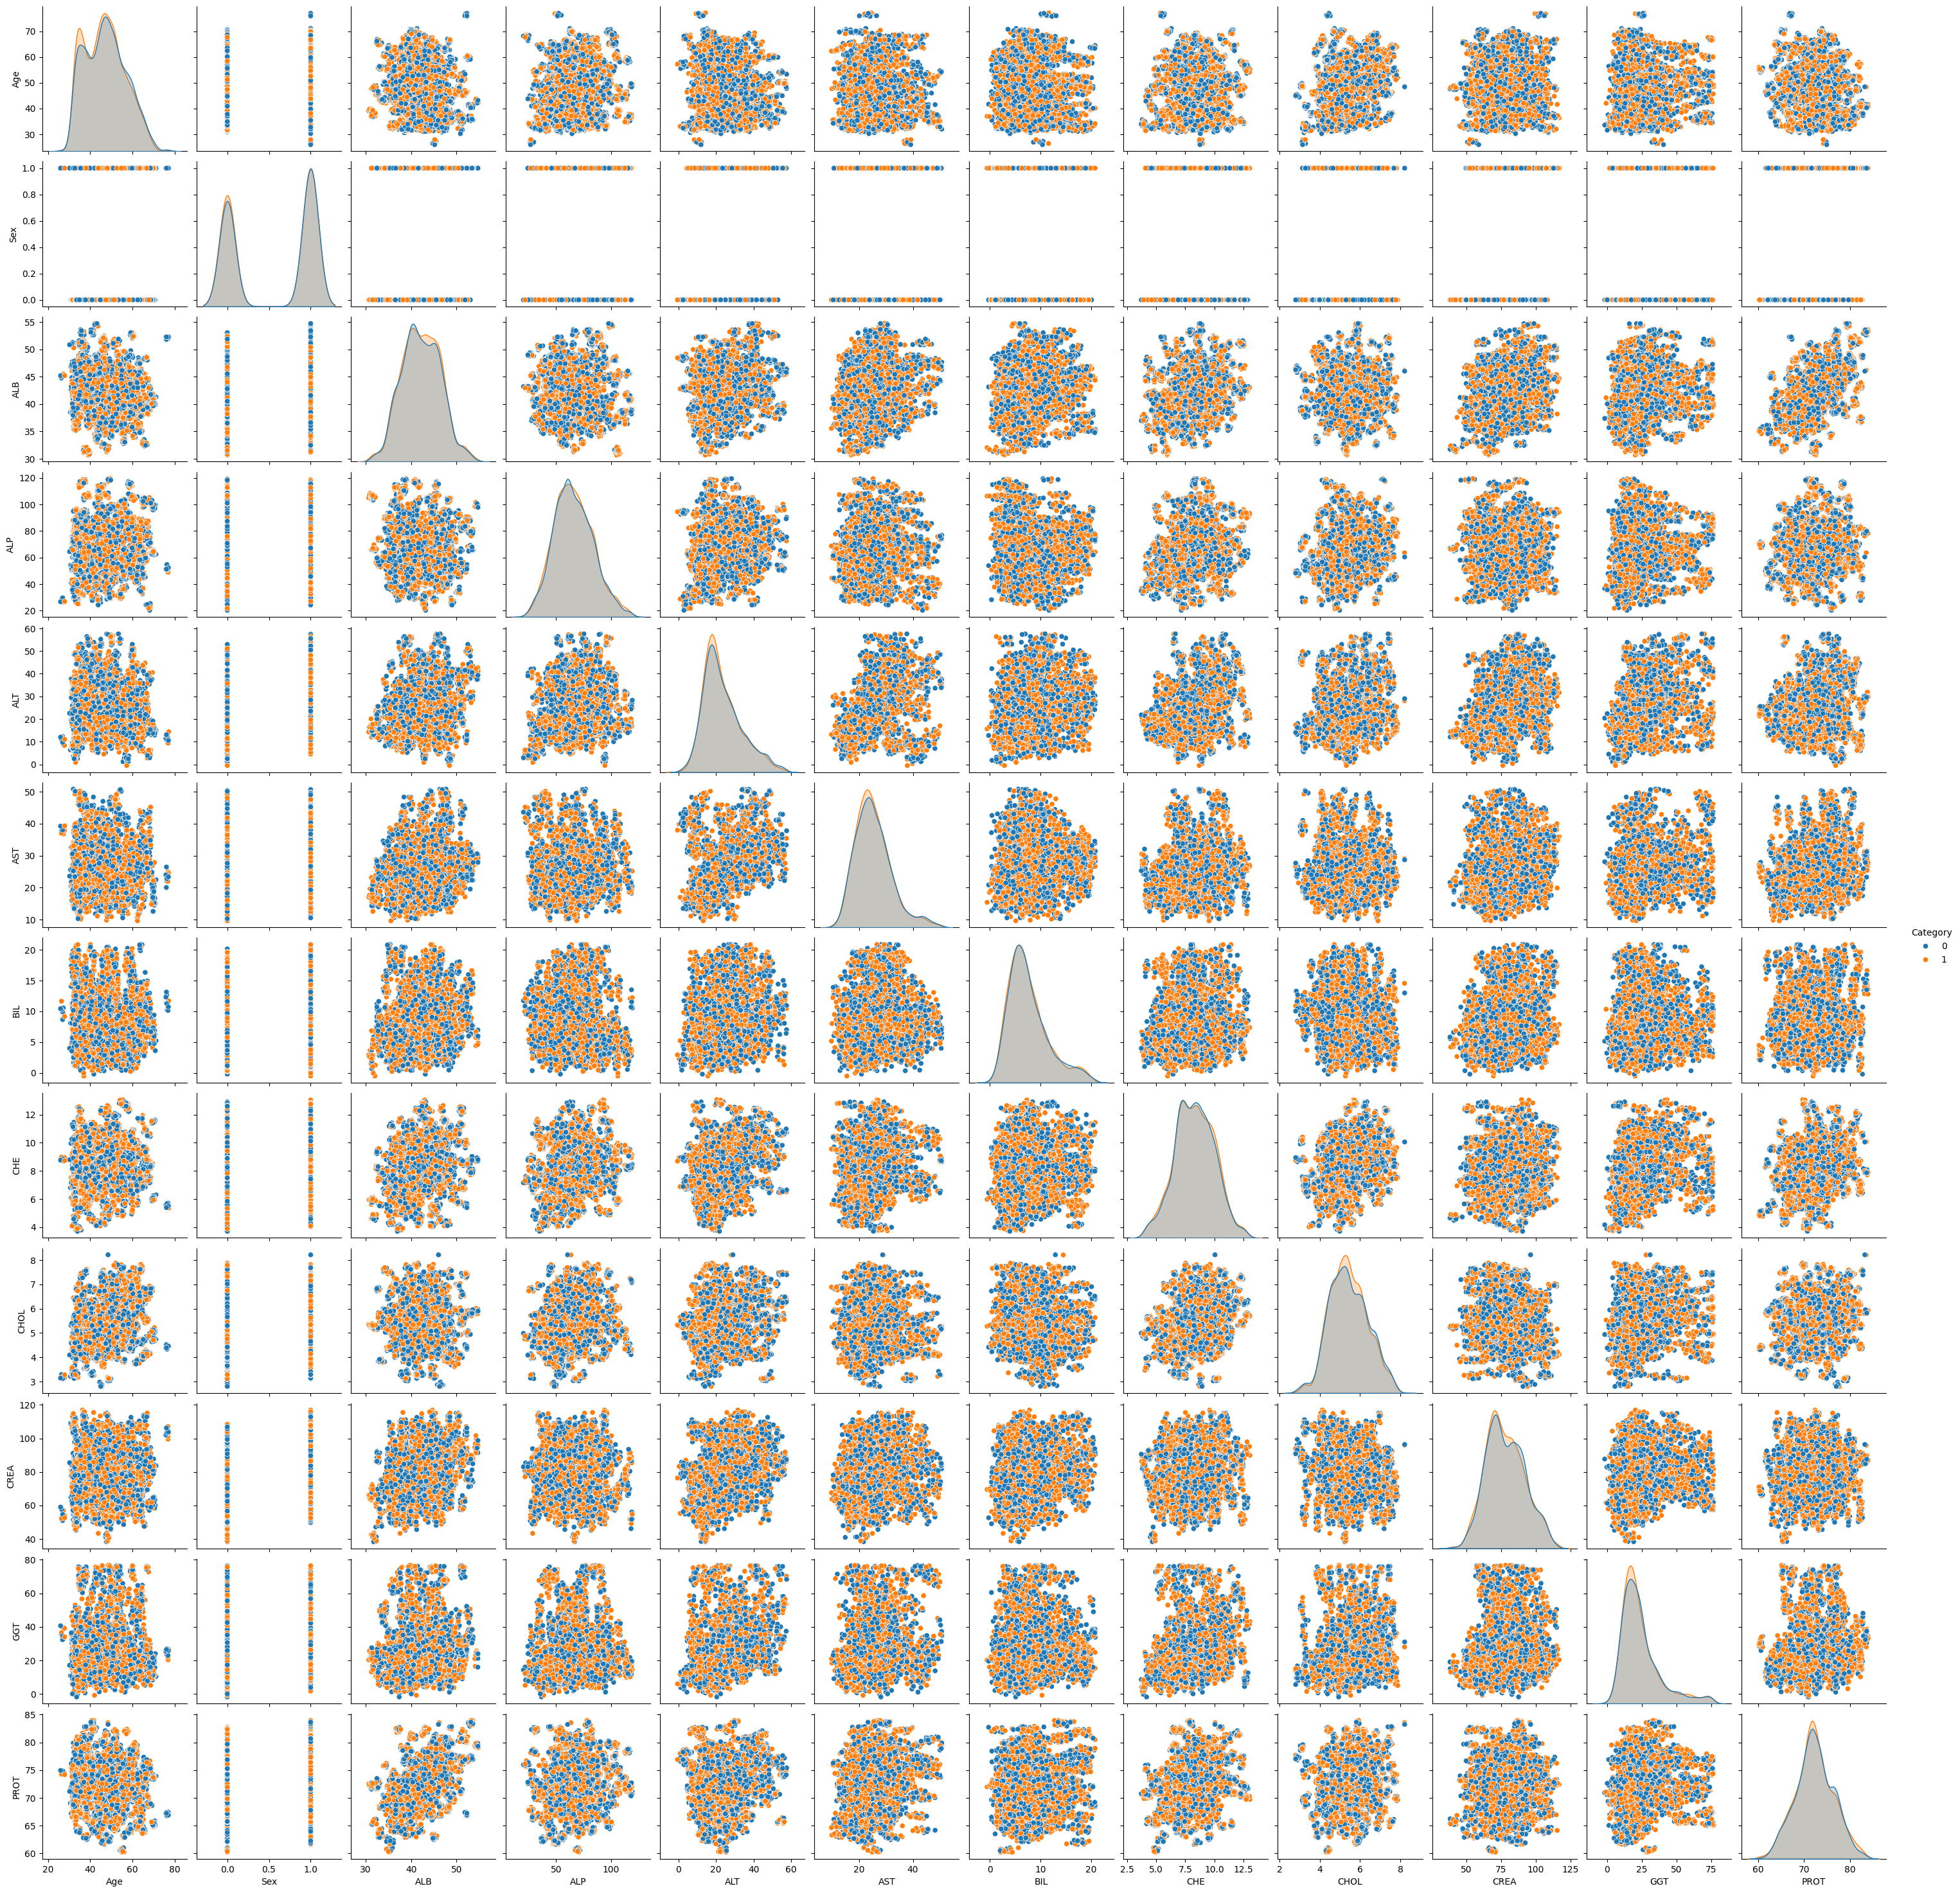

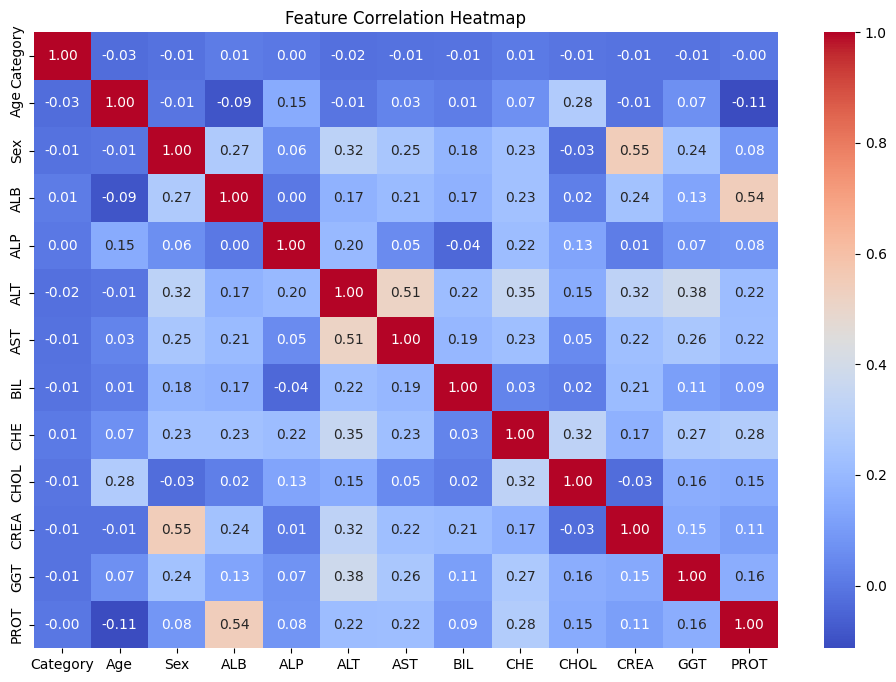

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pairplot
sns.pairplot(df, hue="Category")
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

In [59]:
df['Category'].value_counts()

Category
0    533
1     82
Name: count, dtype: int64

In [61]:
from imblearn.over_sampling import SMOTE

X = df.drop(columns=['Category'])
y = df['Category']

smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

In [38]:
df['Category'].value_counts()

Category
1    3686
0    3611
Name: count, dtype: int64

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(rf, n_features_to_select=5)
rfe.fit(X, y)

selected_features = X.columns[rfe.support_].tolist()
print("Top 5 selected features:", selected_features)

# Use only selected features
X = X[selected_features]

Top 5 selected features: ['Age', 'ALT', 'AST', 'GGT', 'PROT']


In [15]:
selected_features

['Age', 'ALT', 'AST', 'GGT', 'PROT']

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [64]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Define models
models = {
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# Train models
for name, model in models.items():
    model.fit(X_train, y_train)

In [19]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20]
}

gs_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
gs_rf.fit(X_train, y_train)

print("Best parameters for Random Forest:", gs_rf.best_params_)

Best parameters for Random Forest: {'max_depth': 10, 'n_estimators': 50}



Naive Bayes Results:
              precision    recall  f1-score   support

           0       0.49      0.33      0.40       732
           1       0.50      0.66      0.57       728

    accuracy                           0.50      1460
   macro avg       0.50      0.50      0.48      1460
weighted avg       0.50      0.50      0.48      1460



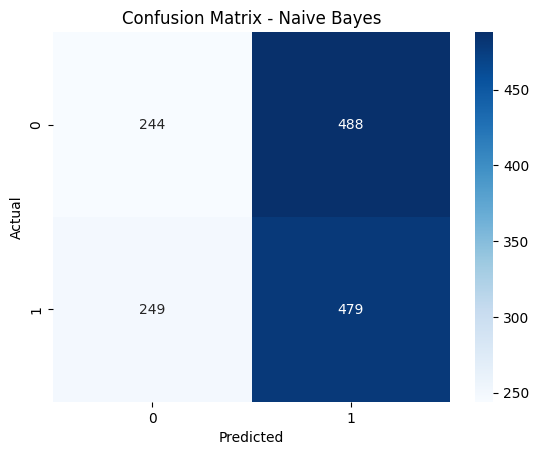


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.50      0.41      0.45       732
           1       0.50      0.59      0.54       728

    accuracy                           0.50      1460
   macro avg       0.50      0.50      0.50      1460
weighted avg       0.50      0.50      0.50      1460



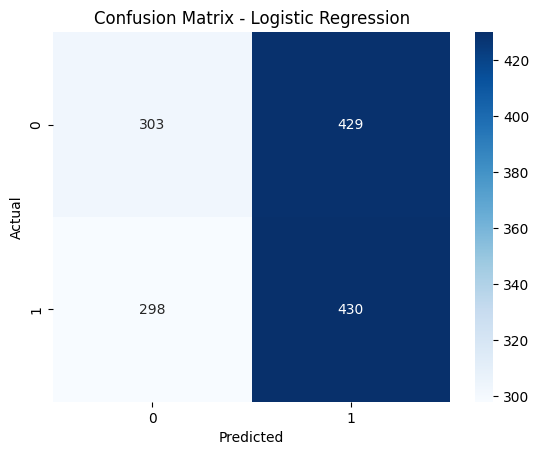


Random Forest Results:
              precision    recall  f1-score   support

           0       0.52      0.50      0.51       732
           1       0.52      0.54      0.53       728

    accuracy                           0.52      1460
   macro avg       0.52      0.52      0.52      1460
weighted avg       0.52      0.52      0.52      1460



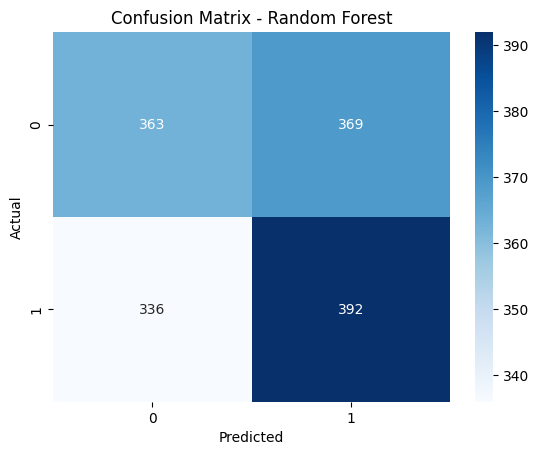


SVM Results:
              precision    recall  f1-score   support

           0       0.51      0.36      0.42       732
           1       0.50      0.66      0.57       728

    accuracy                           0.51      1460
   macro avg       0.51      0.51      0.50      1460
weighted avg       0.51      0.51      0.50      1460



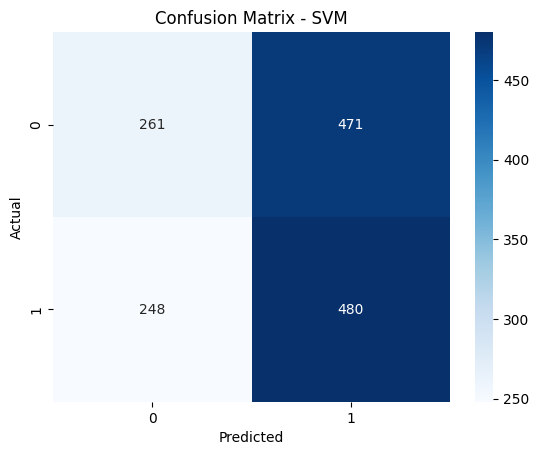


KNN Results:
              precision    recall  f1-score   support

           0       0.49      0.47      0.48       732
           1       0.49      0.51      0.50       728

    accuracy                           0.49      1460
   macro avg       0.49      0.49      0.49      1460
weighted avg       0.49      0.49      0.49      1460



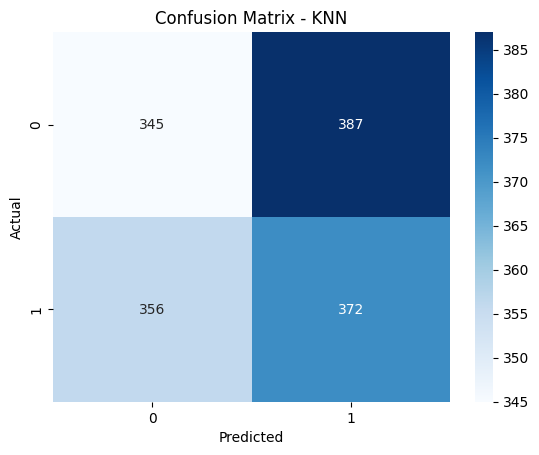


Model Performance Comparison:


Accuracy   ROC AUC
Naive Bayes          0.495205  0.499461
Logistic Regression  0.502055  0.500769
Random Forest        0.517123  0.509356
SVM                  0.507534  0.504008
KNN                  0.491096  0.505108

In [21]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else "N/A"
    results[name] = {"Accuracy": acc, "ROC AUC": roc_auc}

    print(f"\n{name} Results:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Display results
results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
display(results_df)

In [23]:
!pip install xgboost --quiet
from xgboost import XGBClassifier

model234 = XGBClassifier()
model234.fit(X_train, y_train)
print(classification_report(y_test, model234.predict(X_test)))


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
              precision    recall  f1-score   support

           0       0.51      0.51      0.51       732
           1       0.51      0.50      0.50       728

    accuracy                           0.51      1460
   macro avg       0.51      0.51      0.51      1460
weighted avg       0.51      0.51      0.51      1460



/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Figure size 640x480 with 0 Axes>

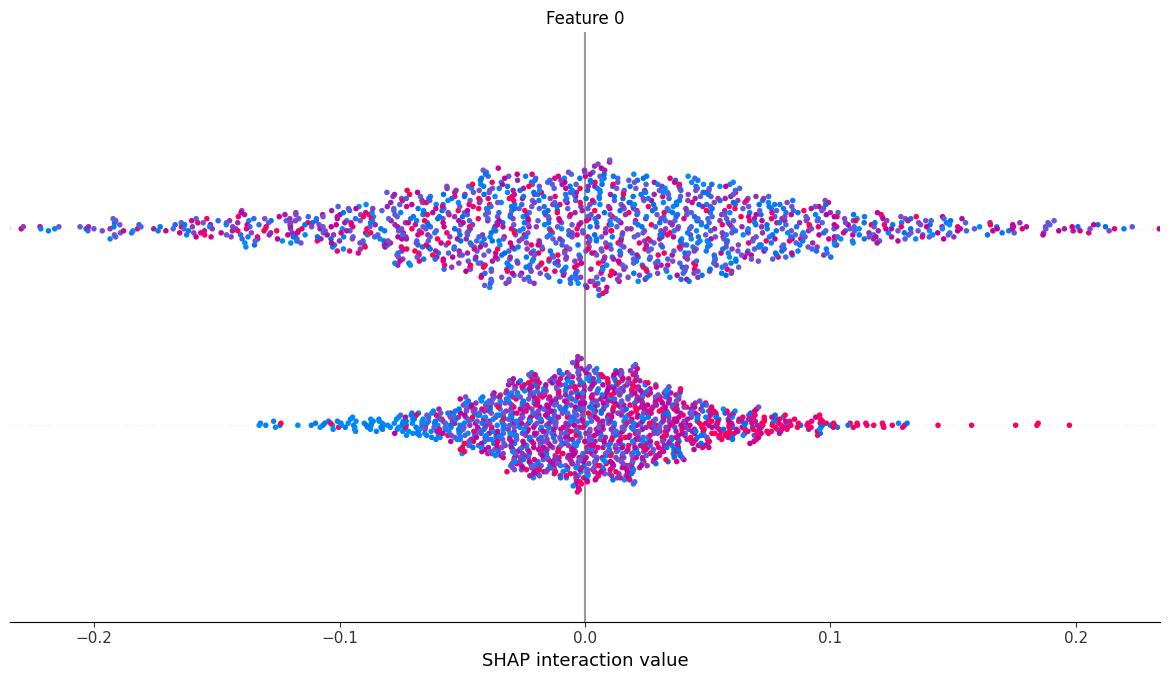

In [24]:
import shap

explainer = shap.Explainer(RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, y_train))
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

In [28]:
import joblib

# Save best model and scaler
joblib.dump(models["Random Forest"], "best_model.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [29]:
import streamlit as st
import joblib

model = joblib.load("best_model.pkl")
scaler = joblib.load("scaler.pkl")

st.title("Hepatitis C Prediction")

data = [st.number_input(col) for col in selected_features]
if st.button("Predict"):
    result = model.predict(scaler.transform([data]))
    st.write("Prediction:", "Hepatitis C" if result[0] == 1 else "Healthy")

2025-03-16 10:47:14.191 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-16 10:47:14.572 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-03-16 10:47:14.574 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-16 10:47:14.577 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-16 10:47:14.578 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-16 10:47:14.581 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-16 10:47:14.586 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-16 10:47:14.590 Session state does not 

In [ ]:
!streamlit run app.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.81.124.128:8501

